In [10]:
import sys
sys.path.insert(1, '../01-scripts/01-modules')

from globals import *
from utils_data import *
from utils_model import *
from utils_bio import *

import matplotlib.ticker as ticker

NOTEBOOK_ID = '14'
RUN_ESM = False
TRAIN_ENSEMBLE = False
RUN_DIAMOND = False

In [2]:
query_df = pd.read_csv(f'{HAMMING_ENSEMBLE_DIR}/03-results/top_models.csv')
df_filtered = pd.read_csv(f'{HAMMING_ENSEMBLE_DIR}/03-results/model_testing_filtered.csv').set_index('file')
sanborn_df = pd.read_csv(f'{DATASET_DIR}/02-sanborn/all_paddle_data.csv').rename(columns={'protein sequence':'AAseq'})

if RUN_ESM:
    model = 'esm2_t33_650M_UR50D'
    layer = 33
    tmp_df = sanborn_df.copy()
    out_faa = f'{HARMONIZE_DIR}/04-results/sanborn.faa'
    embeddings_dir = f'{HARMONIZE_DIR}/04-results/sanborn_{model}'
    out_pkl = f'{HARMONIZE_DIR}/04-results/sanborn_{model}-layer{layer}-representations.pkl'
    seq_col = 'protein sequence'
    
    tmp_df['ID'] = [f'sanborn-{str(i).zfill(5)}' for i in range(len(tmp_df))]
    df_to_fasta(tmp_df,'ID','AAseq',out_faa)
    if len(glob(f'{embeddings_dir}/*')) == 0:
        print('running ESM')
        run_esm(out_faa,
                embeddings_dir,
                model=model,
                layer=layer)
    if not os.path.isfile(out_pkl):
        print('saving representations')
        embedding_df = tmp_df.copy()
        embedding_df[model] = embedding_df['ID'].apply(lambda x: get_embedding(embeddings_dir,x,layer=layer))
        embedding_df.to_pickle(out_pkl)
        del tmp_df, embedding_df

sanborn_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/sanborn_esm2_t33_650M_UR50D-layer33-representations.pkl')
sanborn_test_df = pd.read_csv(f'{LIBRARY_DIR}/sanborn_test.csv').rename(columns={'protein sequence':'AAseq'})
sanborn_other_df = sanborn_df[~sanborn_df['AAseq'].isin(sanborn_test_df['AAseq'])]

In [3]:
if not os.path.isfile(f'{UNCERTAINTY_DIR}/01-dataset/top_mycocosm_uncertainty.pkl'):
    all_mycocosm_df = pd.read_pickle(f'{MYCOCOSM_DIR}/03-clustered_90/output_combined.pkl')
    all_mycocosm_df = all_mycocosm_df[~all_mycocosm_df['tile_id'].isin(mycocosm_df['tile_id'])]
    top_uncertainty = all_mycocosm_df.sort_values('uncertainty',ascending=False).head(10_000).reset_index(drop=True)
    all_mycocosm_df['category'] = pd.cut(all_mycocosm_df['predictions'],10_500)
    categories = all_mycocosm_df['category'].unique()
    top_entries_list = []
    for category in tqdm(categories):
        top_entries = all_mycocosm_df[all_mycocosm_df['category'] == category].nlargest(1, 'uncertainty')
        top_entries_list.append(top_entries)
    top_entries_df = pd.concat(top_entries_list).reset_index(drop=True)
    seqs = {}
    subfiles = glob(f'{MYCOCOSM_DIR}/03-clustered_90/02-subfiles_fasta/*.fasta')
    for subfile in tqdm(subfiles):
        fasta_sequences = SeqIO.parse(open(subfile),'fasta')
        for fasta in fasta_sequences:
            seqs[fasta.name] = str(fasta.seq)
    top_entries_df['seq'] = top_entries_df['tile_id'].apply(lambda x: seqs[x])
    top_entries_df.to_pickle(f'{ACTIVE_LEARNING_DIR}/04-dataset/range_mycocosm_uncertainty.pkl')

    top_uncertainty['seq'] = top_uncertainty['tile_id'].apply(lambda x: seqs[x])
    top_uncertainty.to_pickle(f'{ACTIVE_LEARNING_DIR}/04-dataset/top_mycocosm_uncertainty.pkl')
else:
    top_entries_df = pd.read_pickle(f'{UNCERTAINTY_DIR}/01-dataset/range_mycocosm_uncertainty.pkl').rename(columns={'seq':'AAseq'})
    top_uncertainty = pd.read_pickle(f'{UNCERTAINTY_DIR}/01-dataset/top_mycocosm_uncertainty.pkl').rename(columns={'seq':'AAseq'})

if RUN_ESM:
    model = 'esm2_t33_650M_UR50D'
    layer = 33
    tmp_df = top_uncertainty.copy()
    out_faa = f'{UNCERTAINTY_DIR}/04-dataset/top.faa'
    embeddings_dir = f'{UNCERTAINTY_DIR}/04-dataset/top_{model}'
    out_pkl = f'{UNCERTAINTY_DIR}/04-dataset/top_{model}-layer{layer}-representations.pkl'
    
    tmp_df['ID'] = [f'mycocosm-{str(i).zfill(5)}' for i in range(len(tmp_df))]
    df_to_fasta(tmp_df,'ID','AAseq',out_faa)
    if len(glob(f'{embeddings_dir}/*')) == 0:
        print('running ESM')
        run_esm(out_faa,
                embeddings_dir,
                model=model,
                layer=layer)
    if not os.path.isfile(out_pkl):
        print('saving representations')
        embedding_df = tmp_df.copy()
        embedding_df[model] = embedding_df['ID'].apply(lambda x: get_embedding(embeddings_dir,x,layer=layer))
        embedding_df.to_pickle(out_pkl)
        del tmp_df, embedding_df

In [4]:
mycocosm_df = pd.read_csv(f'{LIBRARY_DIR}/mycocosm_test_codonoptimized.csv').rename(columns={'seq':'AAseq'})

if RUN_ESM:
    model = 'esm2_t33_650M_UR50D'
    layer = 33
    tmp_df = mycocosm_df.copy()
    out_faa = f'{HARMONIZE_DIR}/04-results/mycocosm_test.faa'
    embeddings_dir = f'{HARMONIZE_DIR}/04-results/mycocosm_{model}'
    out_pkl = f'{HARMONIZE_DIR}/04-results/mycocosm_{model}-layer{layer}-representations.pkl'
    seq_col = 'protein sequence'
    
    tmp_df['ID'] = [f'mycocosm-{str(i).zfill(5)}' for i in range(len(tmp_df))]
    df_to_fasta(tmp_df,'ID','AAseq',out_faa)
    if len(glob(f'{embeddings_dir}/*')) == 0:
        print('running ESM')
        run_esm(out_faa,
                embeddings_dir,
                model=model,
                layer=layer)
    if not os.path.isfile(out_pkl):
        print('saving representations')
        embedding_df = tmp_df.copy()
        embedding_df[model] = embedding_df['ID'].apply(lambda x: get_embedding(embeddings_dir,x,layer=layer))
        embedding_df.to_pickle(out_pkl)
        del tmp_df, embedding_df

mycocosm_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/mycocosm_esm2_t33_650M_UR50D-layer33-representations.pkl')

# train new ensemble on harmonized data

## train using entire dataset

In [5]:
if TRAIN_ENSEMBLE:
    harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"')[['esm2_t33_650M_UR50D','linear_harmonized_activity']]
    X = np.asarray([np.array(emb) for emb in harmonized_df['esm2_t33_650M_UR50D']])
    y = harmonized_df['linear_harmonized_activity'].to_numpy()
    thresh = harmonized_df['linear_harmonized_activity'].median()
    y_cont = y.reshape(-1, 1)
    y_bin = (y >= thresh).astype(np.int64).reshape(-1, 1)
    scaler = preprocessing.StandardScaler().fit(y_cont)
    y_cont = scaler.transform(y_cont)

    splitter = StratifiedShuffleSplit(n_splits=1,train_size=0.8,random_state=0)
    train_index, val_test_index = list(splitter.split(X, y_bin))[0]
    X_train = torch.tensor(X[train_index])
    y_cont_train = torch.tensor(y_cont[train_index])
    X_val_test = torch.tensor(X[val_test_index])
    y_cont_val_test = torch.tensor(y_cont[val_test_index])

    dataset = (X_train, None, y_cont_train), (X_val_test, _, y_cont_val_test), (None, None, None)

    # train models
    out_dir = f'{UNCERTAINTY_DIR}/05-evaluate'
    _, selected_indices = select_maximally_different_arrays(df_filtered.to_numpy(), 20)
    hits_df = df_filtered.reset_index()
    hits_df = hits_df.loc[selected_indices].set_index('file')
    for idx, row in query_df[query_df.file.isin(hits_df.index)].iterrows():
        print(f'==================={idx/20}===================')
        train_ds = TensorDataset(X_train.to(torch.float), y_cont_train.to(torch.float))
        val_ds = TensorDataset(X_val_test.to(torch.float), y_cont_val_test.to(torch.float))
        train_dl = DataLoader(train_ds, batch_size=row['batch_size'], shuffle=False)

        val_dl = DataLoader(val_ds, batch_size=row['batch_size'], shuffle=False)

        model = ADhunterSystem_v2(
            embedding_size=X_train[0].shape[1],
            hidden=row['hidden_size'], 
            kernel_size=row['kernel_size'], 
            dilation=row['dilation'], 
            num_res_blocks=row['num_res_blocks'],
            seq_len=X_train[0].shape[0]
            )

        OUTPUT_FILE = f"ADhunter_v2_h{row['hidden_size']}_k{row['kernel_size']}_d{row['dilation']}_r{row['num_res_blocks']}_b{row['batch_size']}_entiredataset"
        csv_logger = CSVLogger(f"{out_dir}/01-logs",name=OUTPUT_FILE,version='')
        checkpoint_callback = ModelCheckpoint(dirpath=f"{out_dir}/02-models", monitor="val_loss", filename=OUTPUT_FILE, save_last=False)
        early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
        trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
        trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

        model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
        torch.save(model.cpu().state_dict(), f'{out_dir}/02-models/{OUTPUT_FILE}.pt')

## train with heldout test dataset

In [6]:
if TRAIN_ENSEMBLE:
    harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"')[['esm2_t33_650M_UR50D','linear_harmonized_activity']]
    X = np.asarray([np.array(emb) for emb in harmonized_df['esm2_t33_650M_UR50D']])
    y = harmonized_df['linear_harmonized_activity'].to_numpy()
    thresh = harmonized_df['linear_harmonized_activity'].median()
    dataset, _  = split_dataset(X,y,thresh)

    train, val, test = dataset
    X_train, _, y_cont_train = train
    X_val, _, y_cont_val = val
    X_test, _, y_cont_test = test

    # train models
    out_dir = f'{UNCERTAINTY_DIR}/05-evaluate'
    _, selected_indices = select_maximally_different_arrays(df_filtered.to_numpy(), 20)
    hits_df = df_filtered.reset_index()
    hits_df = hits_df.loc[selected_indices].set_index('file')
    for idx, row in query_df[query_df.file.isin(hits_df.index)].reset_index(drop=True).iterrows():
        print(f'==================={idx/20}===================')
        train_ds = TensorDataset(X_train.to(torch.float), y_cont_train.to(torch.float))
        val_ds = TensorDataset(X_val.to(torch.float), y_cont_val.to(torch.float))
        train_dl = DataLoader(train_ds, batch_size=row['batch_size'], shuffle=False)
        val_dl = DataLoader(val_ds, batch_size=row['batch_size'], shuffle=False)

        model = ADhunterSystem_v2(
            embedding_size=X_train[0].shape[1],
            hidden=row['hidden_size'], 
            kernel_size=row['kernel_size'], 
            dilation=row['dilation'], 
            num_res_blocks=row['num_res_blocks'],
            seq_len=X_train[0].shape[0]
            )

        OUTPUT_FILE = f"ADhunter_v2_h{row['hidden_size']}_k{row['kernel_size']}_d{row['dilation']}_r{row['num_res_blocks']}_b{row['batch_size']}"
        csv_logger = CSVLogger(f"{out_dir}/01-logs",name=OUTPUT_FILE,version='')
        checkpoint_callback = ModelCheckpoint(dirpath=f"{out_dir}/02-models", monitor="val_loss", filename=OUTPUT_FILE, save_last=False)
        early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
        trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
        trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

        model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
        torch.save(model.cpu().state_dict(), f'{out_dir}/02-models/{OUTPUT_FILE}.pt')

In [7]:
out_file = f'{UNCERTAINTY_DIR}/evaluate_updated_ensemble.pkl'
if not os.path.isfile(out_file):
    harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"')[['AAseq','esm2_t33_650M_UR50D','linear_harmonized_activity','dataset']]
    X = np.asarray([np.array(emb) for emb in harmonized_df['esm2_t33_650M_UR50D']])
    y = harmonized_df['linear_harmonized_activity'].to_numpy()
    thresh = harmonized_df['linear_harmonized_activity'].median()
    dataset, idx  = split_dataset(X,y,thresh)

    train, val, test = dataset
    X_train, _, y_cont_train = train
    X_val, _, y_cont_val = val
    X_test, _, y_cont_test = test

    _,_,test_idx = idx
    harmonized_test_df = harmonized_df.loc[test_idx].copy()
    X = np.asarray([np.array(emb) for emb in harmonized_test_df['esm2_t33_650M_UR50D']])
    y = harmonized_test_df['linear_harmonized_activity'].to_numpy()
    y = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))

    old_predictions, old_uncertainty = get_uncertainty(X_test)
    new_predictions, new_uncertainty = get_new_uncertainty(X_test,entire_dataset=False)

    harmonized_test_df['y_test'] = y_cont_test.numpy().reshape(-1)
    harmonized_test_df['prediction_initial'] = old_predictions
    harmonized_test_df['uncertainty_initial'] = old_uncertainty
    harmonized_test_df['prediction_updated'] = new_predictions
    harmonized_test_df['uncertainty_updated'] = new_uncertainty
    harmonized_test_df['dataset'] = harmonized_test_df['dataset'].replace({'Hummel_Overlap':'Harmonization','Sanborn':'Control','Hummel':'Initial'})
    harmonized_test_df['error_initial'] = harmonized_test_df['prediction_initial'] - harmonized_test_df['y_test']
    harmonized_test_df['error_updated'] = harmonized_test_df['prediction_updated'] - harmonized_test_df['y_test']

    harmonized_test_df['ID'] = [f'test-{str(i).zfill(4)}' for i in harmonized_test_df.index]
    harmonized_test_df.to_pickle(out_file)
else:
    harmonized_test_df = pd.read_pickle(out_file)

# calculate uncertainty of old and new ensembles

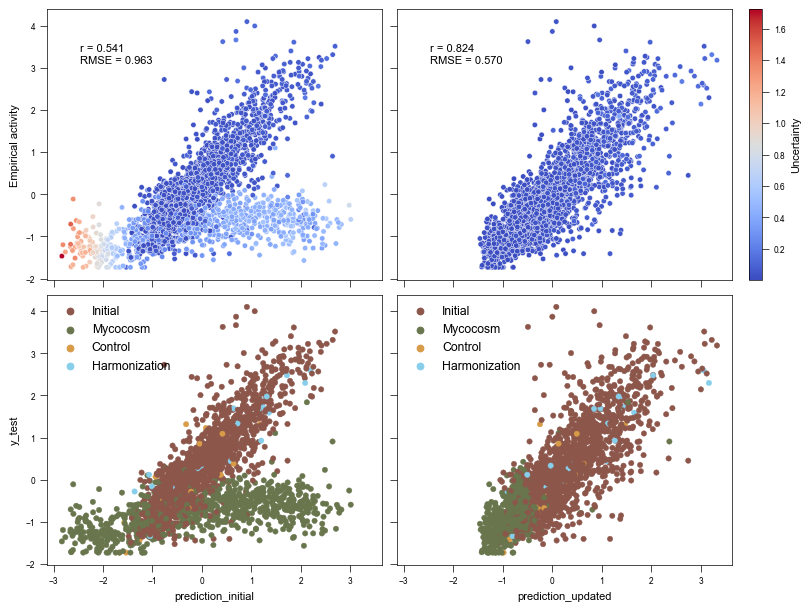

In [8]:
fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(8,6),constrained_layout=True,sharey='row',sharex=True)

vmin = min(harmonized_test_df['uncertainty_initial'].min(), harmonized_test_df['uncertainty_updated'].min())
vmax = max(harmonized_test_df['uncertainty_initial'].max(), harmonized_test_df['uncertainty_updated'].max())

g = sns.scatterplot(data=harmonized_test_df,
                    x='prediction_initial',
                    y='y_test',
                    hue='uncertainty_initial',
                    s=15,
                    palette=sns.color_palette("coolwarm", as_cmap=True),
                    ax=axes[0,0],
                    hue_norm=(vmin, vmax))
r = pearsonr(harmonized_test_df['y_test'],harmonized_test_df['prediction_initial'])[0]
rmse = mean_squared_error(harmonized_test_df['y_test'],harmonized_test_df['prediction_initial'],squared=False)
g.set(xlabel='Predicted activity',ylabel='Empirical activity')
g.get_legend().remove()
g.text(x=0.1,y=0.8,s=f'r = {r:.3f}\nRMSE = {rmse:.3f}',transform=g.transAxes)

g = sns.scatterplot(data=harmonized_test_df,
                    x='prediction_updated',
                    y='y_test',
                    hue='uncertainty_updated',
                    s=15,
                    palette=sns.color_palette("coolwarm", as_cmap=True),
                    ax=axes[0,1],
                    hue_norm=(vmin, vmax))
r = pearsonr(harmonized_test_df['y_test'],harmonized_test_df['prediction_updated'])[0]
rmse = mean_squared_error(harmonized_test_df['y_test'],harmonized_test_df['prediction_updated'],squared=False)
g.set(xlabel='Predicted activity',ylabel='Harmonized activity')
g.get_legend().remove()
g.text(x=0.1,y=0.8,s=f'r = {r:.3f}\nRMSE = {rmse:.3f}',transform=g.transAxes)

norm = plt.Normalize(vmin, vmax)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
cbar = g.figure.colorbar(sm, ax=axes[0,1],label='Uncertainty')


g = sns.scatterplot(data=harmonized_test_df,
                x='prediction_initial',
                y='y_test',
                hue='dataset',
                ax=axes[1,0],
                s=15,
                palette=[COLORS[10],'#69764d','#d89b47','skyblue'],
                edgecolor=None)
g.legend(frameon=False)

g = sns.scatterplot(data=harmonized_test_df,
                x='prediction_updated',
                y='y_test',
                hue='dataset',
                ax=axes[1,1],
                s=15,
                palette=[COLORS[10],'#69764d','#d89b47','skyblue'],
                edgecolor=None)
g.legend(frameon=False)

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-active_learning_uncertainty.png',dpi=400,transparent=False,bbox_inches='tight')

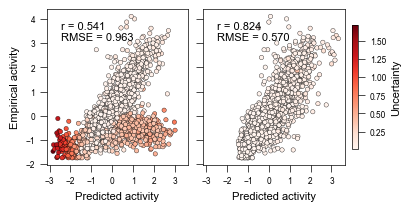

In [11]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(4,2),constrained_layout=True,sharey='row',sharex=True)

vmin = min(harmonized_test_df['uncertainty_initial'].min(), harmonized_test_df['uncertainty_updated'].min())
vmax = max(harmonized_test_df['uncertainty_initial'].max(), harmonized_test_df['uncertainty_updated'].max())

g = sns.scatterplot(data=harmonized_test_df,
                    x='prediction_initial',
                    y='y_test',
                    hue='uncertainty_initial',
                    s=10,
                    palette=sns.color_palette("Reds", as_cmap=True),
                    ax=axes[0],
                    hue_norm=(vmin, vmax),edgecolor='black')
r = pearsonr(harmonized_test_df['y_test'],harmonized_test_df['prediction_initial'])[0]
rmse = mean_squared_error(harmonized_test_df['y_test'],harmonized_test_df['prediction_initial'],squared=False)
g.set(xlabel='Predicted activity',ylabel='Empirical activity')
g.get_legend().remove()
g.text(x=0.1,y=0.8,s=f'r = {r:.3f}\nRMSE = {rmse:.3f}',transform=g.transAxes)

g = sns.scatterplot(data=harmonized_test_df,
                    x='prediction_updated',
                    y='y_test',
                    hue='uncertainty_updated',
                    s=10,
                    palette=sns.color_palette("Reds", as_cmap=True),
                    ax=axes[1],
                    hue_norm=(vmin, vmax),
                    edgecolor='black')
r = pearsonr(harmonized_test_df['y_test'],harmonized_test_df['prediction_updated'])[0]
rmse = mean_squared_error(harmonized_test_df['y_test'],harmonized_test_df['prediction_updated'],squared=False)
g.set(xlabel='Predicted activity',ylabel='Harmonized activity')
g.get_legend().remove()
g.text(x=0.1,y=0.8,s=f'r = {r:.3f}\nRMSE = {rmse:.3f}',transform=g.transAxes)
norm = plt.Normalize(vmin, vmax)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
cbar = g.figure.colorbar(sm, ax=axes[1],label='Uncertainty',shrink=0.8)
g.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-active_learning_uncertainty.svg',transparent=True,bbox_inches='tight')

In [12]:
if RUN_DIAMOND:
    df_to_fasta(harmonized_test_df,'ID','AAseq',f'{UNCERTAINTY_DIR}/test_seqs.faa')

    !diamond blastp -d ../../01-INPUT/02-datasets/03-waldburger/mycocosm_db.dmnd \
        -q ../../02-OUTPUT/19-evaluate_uncertainty/test_seqs.faa \
            -o ../../02-OUTPUT/19-evaluate_uncertainty/test_seq_matches.tsv --id 100
cols = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen','qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
matches_df = pd.read_csv(f'{UNCERTAINTY_DIR}/test_seq_matches.tsv',sep='\t',names=cols)
matches_df = matches_df.query('length == 53').reset_index(drop=True)
matches_df['organism_id'] = matches_df['sseqid'].apply(lambda x: x.split('-')[0])
matches_df = matches_df.merge(harmonized_test_df,left_on='qseqid',right_on='ID') #4109 -> 4109
matches_df = matches_df.drop(columns=['qseqid','qend','send','sseqid','pident','length','mismatch','gapopen','qstart','sstart','evalue','bitscore','linear_harmonized_activity','AAseq'])
matches_df['dataset'] = matches_df['dataset'].replace({'Hummel_Overlap':'Hummel'})
matches_df.to_pickle(f'{UNCERTAINTY_DIR}/matches.pkl')
matches_df

,organism_id,esm2_t33_650M_UR50D,dataset,y_test,prediction_initial,uncertainty_initial,prediction_updated,uncertainty_updated,error_initial,error_updated,ID
0,Stepol1,"[[0.07058463, -0.073498525, -0.09366397, -0.06...",Mycocosm,-0.672246,-0.450104,0.279177,-0.564854,0.034470,0.222142,0.107392,test-7300
1,Sacboulardii,"[[0.033802085, 0.08967299, -0.03680888, 0.0825...",Initial,0.444670,0.192101,0.037311,0.500373,0.039572,-0.252569,0.055703,test-23061
2,Sacce1,"[[0.033802085, 0.08967299, -0.03680888, 0.0825...",Initial,0.444670,0.192101,0.037311,0.500373,0.039572,-0.252569,0.055703,test-23061
3,SacceM3707,"[[0.033802085, 0.08967299, -0.03680888, 0.0825...",Initial,0.444670,0.192101,0.037311,0.500373,0.039572,-0.252569,0.055703,test-23061
4,SacceM3836,"[[0.033802085, 0.08967299, -0.03680888, 0.0825...",Initial,0.444670,0.192101,0.037311,0.500373,0.039572,-0.252569,0.055703,test-23061
...,...,...,...,...,...,...,...,...,...,...,...
4104,SacceM3837,"[[-0.024888963, -0.11419804, -0.11365327, 0.07...",Initial,-0.454903,-0.622286,0.020466,-0.318544,0.021892,-0.167383,0.136359,test-22892
4105,SacceM3838,"[[-0.024888963, -0.11419804, -0.11365327, 0.07...",Initial,-0.454903,-0.622286,0.020466,-0.318544,0.021892,-0.167383,0.136359,test-22892
4106,SacceM3839,"[[-0.024888963, -0.11419804, -0.11365327, 0.07...",Initial,-0.454903,-0.622286,0.020466,-0.318544,0.021892,-0.167383,0.136359,test-22892
4107,Elsamp1,"[[0.013080612, -0.10999128, -0.021107104, -0.0...",Mycocosm,-1.317926,0.192343,0.351878,-0.492994,0.029249,1.510269,0.824932,test-7276


In [13]:
(matches_df
 .groupby(['organism_id'])['error_updated']
 .max()
 .reset_index()
 .rename(columns={'error_updated':'error_updated_max'})
 .to_csv(f'{UNCERTAINTY_DIR}/test_error_updated_max.csv',index=False))

(matches_df
 .groupby(['organism_id'])['error_initial']
 .max()
 .reset_index()
 .rename(columns={'error_initial':'error_initial_max'})
 .to_csv(f'{UNCERTAINTY_DIR}/test_error_initial_max.csv',index=False))

(matches_df
 .groupby(['organism_id'])['uncertainty_updated']
 .max()
 .reset_index()
 .rename(columns={'uncertainty_updated':'uncertainty_updated_max'})
 .to_csv(f'{UNCERTAINTY_DIR}/test_uncertainty_updated_max.csv',index=False))

(matches_df
 .groupby(['organism_id'])[['uncertainty_initial','uncertainty_updated']]
 .max()
 .reset_index()
 .rename(columns={'uncertainty_initial':'uncertainty_initial_max'})
 .to_csv(f'{UNCERTAINTY_DIR}/test_uncertainty_max.csv',index=False))

count_df = (matches_df
            .groupby(['organism_id'])['ID']
            .count()
            .reset_index()
            .rename(columns={'ID':'count'}))
count_df['log10count'] = np.log10(count_df['count'])
count_df.to_csv(f'{UNCERTAINTY_DIR}/test_counts.csv',index=False)

In [16]:
tmp_df = (matches_df
    .groupby(['organism_id'])[['uncertainty_initial','uncertainty_updated','error_initial','error_updated']]
    .max()
    .rename(columns={'uncertainty_initial':'uncertainty_initial_max',
                    'uncertainty_updated':'uncertainty_updated_max',
                    'error_initial':'error_initial_max',
                    'error_updated':'error_updated_max'})
    .reset_index())
tmp_df

,organism_id,uncertainty_initial_max,uncertainty_updated_max,error_initial_max,error_updated_max
0,Abobi1,0.336035,0.022110,0.438712,0.212899
1,Abobie1,0.336035,0.022110,0.438712,0.212899
2,Abscae1,0.467836,0.024617,1.430515,0.528457
3,Absrep1,0.388957,0.037780,1.772357,0.700469
4,Acain1,0.296490,0.045650,0.357579,0.247979
...,...,...,...,...,...
401,Zoorad1,0.491447,0.029809,1.558922,0.345405
402,Zycmex1,0.499603,0.030177,2.258361,0.622153
403,Zyghet1,0.435223,0.019607,1.792194,-0.058139
404,Zygro1,0.028205,0.034337,-0.433699,-0.147498


In [32]:
tmp_df = matches_df.copy()
tmp_df[['error_initial','error_updated']] = tmp_df[['error_initial','error_updated']].apply(abs,axis=1)
tmp_df = (tmp_df
    .groupby(['organism_id'])[['uncertainty_initial','uncertainty_updated','error_initial','error_updated']]
    .median()
    .rename(columns={'uncertainty_initial':'uncertainty_initial_max',
                    'uncertainty_updated':'uncertainty_updated_max',
                    'error_initial':'error_initial_max',
                    'error_updated':'error_updated_max'})
    .reset_index())
tmp_df.to_csv(f'{UNCERTAINTY_DIR}/test_uncertainty_error_median.csv')

tmp_df

,organism_id,uncertainty_initial_max,uncertainty_updated_max,error_initial_max,error_updated_max
0,Abobi1,0.336035,0.022110,0.438712,0.212899
1,Abobie1,0.336035,0.022110,0.438712,0.212899
2,Abscae1,0.367227,0.022237,1.105598,0.371734
3,Absrep1,0.262692,0.024642,0.872886,0.638201
4,Acain1,0.296490,0.045650,0.357579,0.247979
...,...,...,...,...,...
401,Zoorad1,0.416716,0.024096,1.088696,0.167219
402,Zycmex1,0.498718,0.020558,1.658717,0.237915
403,Zyghet1,0.435223,0.019607,1.792194,0.058139
404,Zygro1,0.027332,0.031505,0.446969,0.176923


In [38]:
(matches_df.groupby(['organism_id'])
 .count()).to_csv(f'{UNCERTAINTY_DIR}/test_count')

,esm2_t33_650M_UR50D,dataset,y_test,prediction_initial,uncertainty_initial,prediction_updated,uncertainty_updated,error_initial,error_updated,ID
organism_id,,,,,,,,,,
Abobi1,1,1,1,1,1,1,1,1,1,1
Abobie1,1,1,1,1,1,1,1,1,1,1
Abscae1,2,2,2,2,2,2,2,2,2,2
Absrep1,3,3,3,3,3,3,3,3,3,3
Acain1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
Zoorad1,4,4,4,4,4,4,4,4,4,4
Zycmex1,3,3,3,3,3,3,3,3,3,3
Zyghet1,1,1,1,1,1,1,1,1,1,1


<Axes: ylabel='organism_id'>

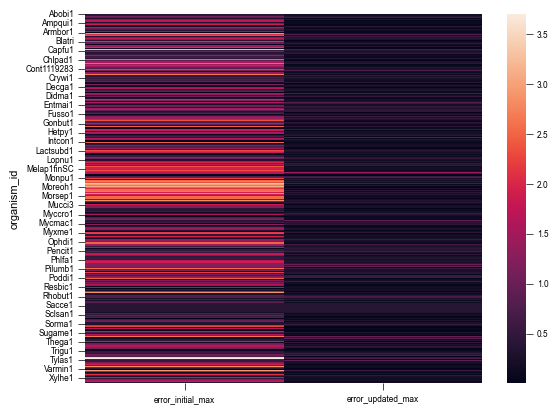

In [34]:
sns.heatmap(tmp_df.set_index('organism_id')[['error_initial_max','error_updated_max']])